# Spatially varying anisotropy (using a Python function)

**Author** Hans Fangohr, images Max Albert

** Date** Jan 2013, updated Jan 2015 (Max Albert)

**Purpose** Demonstrate how material parameters can vary as a function of space.

In [1]:
import time ; print("Last time executed {}".format(time.asctime()))

Last time executed Fri Nov 13 13:16:08 2015


In [2]:
%matplotlib inline

In [3]:
import os
import pylab
import finmag
import numpy as np
import dolfin as df

from finmag import Simulation
from finmag.energies import UniaxialAnisotropy, Exchange, Demag

[2015-11-13 13:16:15] INFO: Finmag logging output will be appended to file: '/home/mb4e10/.finmag/global.log'
[2015-11-13 13:16:15] DEBUG: Building modules in 'native'...
[2015-11-13 13:16:15] DEBUG: FinMag          3042844973cf14bc02c909b16ece9847aa26b637
[2015-11-13 13:16:15] DEBUG: Dolfin          1.6.0                Matplotlib      1.4.2               
[2015-11-13 13:16:15] DEBUG: Numpy           1.10.1               Scipy           0.15.1              
[2015-11-13 13:16:15] DEBUG: IPython         4.0.0                Python          2.7.6               
[2015-11-13 13:16:15] DEBUG: Paraview        4.0.1-1ubuntu1       Sundials        2.5.0               
[2015-11-13 13:16:15] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 14.04.3 LTS  
[2015-11-13 13:16:15] DEBUG: Registering debug signal handler. Press Ctrl-Z any time to stop execution and jump into the debugger.


Demonstrating spatially varying anisotropy. Example with anisotropy vectors as follows:

```
-----------------------------------

--> --> --> --> --> --> --> --> -->
--> --> --> --> --> --> --> --> -->
--> --> --> --> --> --> --> --> -->

-----------------------------------

^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
|  |  |  |  |  |  |  |  |  |  |  | 
|  |  |  |  |  |  |  |  |  |  |  | 

-----------------------------------
```

Define the material constants...

In [4]:
mu0   = 4.0 * np.pi * 10**-7  # vacuum permeability             N/A^2
Ms    = 1.0e6                 # saturation magnetisation        A/m
A     = 13.0e-12              # exchange coupling strength      J/m
Km    = 0.5 * mu0 * Ms**2     # magnetostatic energy density scale   kg/ms^2
lexch = (A/Km)**0.5           # exchange length                 m
K1    = Km*0.1

... and the mesh geometry.

In [6]:
L = lexch # cube length in m
nx = 10
Lx = nx*L
ny = 1
Ly = ny*L
nz = 30
Lz = nz*L
mesh = df.BoxMesh(df.Point(0, 0, 0), df.Point(Lx, Ly, Lz), nx, ny, nz)

In [7]:
# Anisotropy direction starts is [0,0,1] in lower half of the film
# and [1,0,0] in upper half. This is a toy model of the exchange spring
# systems that Bob Stamps is working on.

def expr_a(pt):
    x, y, z = pt
    if z <= 0.5*Lz:
        return [0, 0, 1]
    else:
        return [1, 0, 0]
    
# Alternatively, one can use the following dolfin Expression, but this is much less readable.
#
#expr_a = df.Expression((\"x[2]<=Lz/2. ? 0 : 1\",\"0\", \"x[2]<=Lz/2. ? 1 : 0\"), Lz=Lz)

We can directly use this Python function to create a `UniaxialAnisotropy` object which gets added to our simulation.

In [8]:
sim = Simulation(mesh, Ms)
sim.set_m([1, 0, 1])
sim.add(UniaxialAnisotropy(K1, expr_a))
sim.add(Exchange(A))

[2015-11-13 13:16:48] INFO: Finmag logging output will be written to file: '/home/mb4e10/finmag/doc/ipython_notebooks_src/unnamed.log' (any old content will be overwritten).
[2015-11-13 13:16:48] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2015-11-13 13:16:48] INFO: Creating Sim object name='unnamed', instance_id=0 (rank=0/1).
[2015-11-13 13:16:48] DEBUG:    Total number of Sim objects in this session: 1
[2015-11-13 13:16:48] INFO: <Mesh of topological dimension 3 (tetrahedra) with 682 vertices and 1800 cells, ordered>
/usr/local/lib/python2.7/dist-packages/aeon/timer.py:35: UserWarning: You are nesting measurements in __init__::LLG.
  warnings.warn("You are nesting measurements in {}::{}.".format(name, group))
[2015-11-13 13:16:48] DEBUG: Creating LLG object.
[2015-11-13 13:16:48] DEBUG: Creating UniaxialAnisotropy object with method box-matrix-petsc, in Jacobian.
[2015-11-13 13:16:48] DEBUG: Adding interaction Anisotropy to simulation.
[2015-11-13 13:16:49] DEBUG: Creating Exc

Run the simulation for 1 ns...

In [9]:
#sim.relax()
sim.run_until(1e-9)

[2015-11-13 13:16:57] INFO: Simulation will run until t = 1e-09 s.
[2015-11-13 13:16:57] INFO: Creating integrator with backend sundials and arguments {'reltol': 1e-06, 'abstol': 1e-06}.
[2015-11-13 13:16:57] DEBUG: Updating get method for steps in TableWriter(name=unnamed.ndt)
[2015-11-13 13:16:57] DEBUG: Updating get method for last_step_dt in TableWriter(name=unnamed.ndt)
[2015-11-13 13:16:57] DEBUG: Updating get method for dmdt in TableWriter(name=unnamed.ndt)
/usr/local/lib/python2.7/dist-packages/aeon/timer.py:35: UserWarning: You are nesting measurements in compute_field::UniaxialAnisotropy.
  warnings.warn("You are nesting measurements in {}::{}.".format(name, group))
/usr/local/lib/python2.7/dist-packages/aeon/timer.py:35: UserWarning: You are nesting measurements in compute_field::Exchange.
  warnings.warn("You are nesting measurements in {}::{}.".format(name, group))
[2015-11-13 13:17:07] INFO: Simulation has reached time t = 1e-09 s.


... and plot the result.

/usr/lib/python2.7/dist-packages/dolfin/functions/function.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if len(args) == 1 and args[0] in ('+','-'):


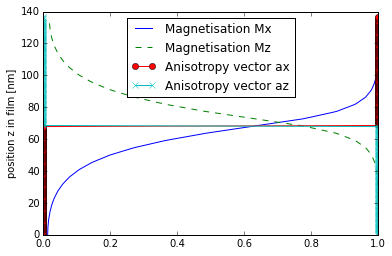

In [10]:
# Create a simple plot
xpos=[]
Mx = []
Mz = []
ax = []
az = []

## For plotting, we probe the field at 200 points
## along a line in z-direction.
probing_pts, probed_vals = \
    sim.probe_field_along_line('m',
                               [Lx/2., Ly/2., 0],
                               [Lx/2., Ly/2, Lz],
                               N=200)
zs = probing_pts[:, 2]
Mx = probed_vals[:, 0]
Mz = probed_vals[:, 2]

## We also evaluate the original profile 
a_vals = np.array([expr_a(pos) for pos in probing_pts])
ax = a_vals[:, 0]
az = a_vals[:, 2]
    
pylab.plot(Mx, zs/1e-9, '-', label='Magnetisation Mx')
pylab.plot(Mz, zs/1e-9, '--', label='Magnetisation Mz')
pylab.plot(ax, zs/1e-9, '-o', label='Anisotropy vector ax')
pylab.plot(az, zs/1e-9, '-x', label='Anisotropy vector az')
pylab.ylabel('position z in film [nm]')
pylab.legend(loc='upper center')

#this only works with an X-display, so comment out for jenkins
#v = df.plot(sim.llg._m, 
#            title='exchange spring across layers with different anisotropy directions',
#            axes=True)

#v.elevate(-90) 
#v.update(sim.llg._m)    # bring settings above into action
##v.write_png(os.path.join(MODULE_DIR,'exchangespring.png')) #this is broken in my dolfin, HF
#                                                            #the bitmap looks random  
#v.write_ps(os.path.join(MODULE_DIR,'exchangespring'))       #will write exchangespring.eps
#os.system("ps2png exchangespring.eps exchangespring.png")   #create the png file for documentation